# IA et Médecine Personnalisée

**UE IA en Santé - Module 5**

*Université de Toulouse - Faculté de Santé*

---

### 🎯 Objectifs

1. Comprendre le passage de l'inférence populationnelle à la prédiction individuelle
2. Maîtriser le concept d'enveloppe convexe et ses implications cliniques
3. Découvrir les jumeaux numériques
4. Appréhender le data overload et les solutions IA

### 📚 Plan (2h)

**Partie 1 (45 min)** : Fondamentaux - Stats vs ML, Enveloppe Convexe

**Partie 2 (45 min)** : Digital Twins et Applications Cliniques

**Partie 3 (30 min)** : Data Overload et Finalités de l'IA

---

💡 **Ce notebook est interactif** : Utilisez les sliders et boutons pour explorer les concepts !

In [52]:
# 📦 Chargement de l'environnement
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider, Dropdown, Button, Output, VBox, HBox, HTML
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
from scipy.spatial import ConvexHull
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    file_path = "framingham.csv"

    df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "aasheesh200/framingham-heart-study-dataset",
    file_path)
    print("✅ Jeu de données chargé avec succès !")
except Exception as e:
    print("❌ Échec du chargement du jeu de données :", e)
    try:
        df = pd.read_csv("framingham.csv")
        df_clean = df.dropna()
        print("✅ Jeu de données chargé depuis le fichier local avec succès !")
    except Exception as e:
        print("❌ Échec du chargement du jeu de données local :", e)
        df = pd.DataFrame()  # Jeu de données vide en cas d'échec


print("✅ Environnement prêt !")
print("🎮 Utilisez les widgets interactifs ci-dessous")

❌ Échec du chargement du jeu de données : cannot import name 'get_access_token_from_env' from 'kagglesdk.kaggle_env' (/home/poette.m/code_tuto/venv/lib/python3.10/site-packages/kagglesdk/kaggle_env.py)
✅ Jeu de données chargé depuis le fichier local avec succès !
✅ Environnement prêt !
🎮 Utilisez les widgets interactifs ci-dessous


# 🏥 Préambule : Présentation du jeu de données : Framingham Heart Study

**L'étude Framingham** est une des études de cohorte les plus célèbres en cardiologie :
- 🗓️ **Début** : 1948, Framingham (Massachusetts, USA)
- 👥 **Population** : >4,000 participants suivis sur plusieurs décennies
- 🎯 **Objectif** : Identifier les facteurs de risque cardiovasculaire
- 📈 **Contributions majeures** : Concept de "facteur de risque", rôle du cholestérol, HTA, tabac...

**Variables disponibles** (16 au total) :
- **Démographiques** : Âge, sexe, niveau d'éducation
- **Comportementales** : Tabagisme (oui/non + cigarettes/jour)
- **Cliniques** : Pression artérielle (systolique/diastolique), fréquence cardiaque
- **Biologiques** : Cholestérol total, glycémie
- **Anthropométriques** : IMC (BMI)
- **Antécédents** : AVC, HTA, diabète, traitement antihypertenseur
- **Outcome** : Risque de maladie coronarienne à 10 ans (TenYearCHD)

🎯 **Objectif** : Prédire le risque cardiovasculaire à 10 ans

Dataset disponible librement : [Kaggle](https://www.kaggle.com/datasets/aasheesh200/framingham-heart-study-dataset)

## 👤 SÉLECTION DE NOTRE PATIENT TÉMOIN

In [59]:
# Tirage aléatoire d'un patient
patient_index = np.random.randint(0, len(df_clean))
patient_data = df_clean.iloc[patient_index].copy()

# Retirer ce patient du dataset d'analyse
df_analysis = df_clean.drop(df_clean.index[patient_index]).reset_index(drop=True)

# Formatage adapté au sexe
is_male = patient_data['male'] == 1
sexe = "Homme" if is_male else "Femme"
nom_patient = "M. Dupont" if is_male else "Mme Martin"
pronom_possessif = "SON" if is_male else "SON"  # "son" risque (invariable)
article = "Ce patient" if is_male else "Cette patiente"

# Mapping niveau d'éducation
education_labels = {
    1.0: "Lycée non terminé",
    2.0: "Diplôme de lycée",
    3.0: "Études supérieures partielles",
    4.0: "Diplôme universitaire"
}
education_str = education_labels.get(patient_data['education'], "Non renseigné")

print("="*70)
print(f"👤 PRÉSENTATION DE NOTRE PATIENT TÉMOIN : {nom_patient}")
print("="*70)
print("\n📋 Caractéristiques :\n")

# Variables binaires
fumeur = "Oui" if patient_data['currentSmoker'] == 1 else "Non"
fumeur_label = "Fumeur actif" if is_male else "Fumeuse active"
hta = "Oui" if patient_data['prevalentHyp'] == 1 else "Non"
diabete = "Oui" if patient_data['diabetes'] == 1 else "Non"
traitement_hta = "Oui" if patient_data['BPMeds'] == 1 else "Non"
risque_reel = "OUI ⚠️" if patient_data['TenYearCHD'] == 1 else "NON ✅"

print(f"   • Sexe                  : {sexe}")
print(f"   • Âge                   : {int(patient_data['age'])} ans")
print(f"   • Niveau d'éducation    : {education_str} ({int(patient_data['education'])}/4)")
print(f"   • IMC                   : {patient_data['BMI']:.1f} kg/m²")
print(f"   • {fumeur_label:23s}: {fumeur}")
if patient_data['currentSmoker'] == 1:
    print(f"     → {int(patient_data['cigsPerDay'])} cigarettes/jour")
print(f"\n   • PA systolique         : {patient_data['sysBP']:.0f} mmHg")
print(f"   • PA diastolique        : {patient_data['diaBP']:.0f} mmHg")
print(f"   • Fréquence cardiaque   : {patient_data['heartRate']:.0f} bpm")
print(f"\n   • Cholestérol total     : {patient_data['totChol']:.0f} mg/dL")
print(f"   • Glycémie              : {patient_data['glucose']:.0f} mg/dL")
print(f"\n   • Antécédent d'HTA      : {hta}")
print(f"   • Traitement anti-HTA   : {traitement_hta}")
print(f"   • Diabète               : {diabete}")
print(f"\n" + "="*70)
print(f"❓ RISQUE CARDIOVASCULAIRE RÉEL (à 10 ans) : {risque_reel}")
print("="*70)

# Sauvegarder pour usage ultérieur
patient_dict = patient_data.to_dict()
patient_dict['nom_affichage'] = nom_patient
patient_dict['sexe_str'] = sexe
patient_dict['is_male'] = is_male

👤 PRÉSENTATION DE NOTRE PATIENT TÉMOIN : Mme Martin

📋 Caractéristiques :

   • Sexe                  : Femme
   • Âge                   : 41 ans
   • Niveau d'éducation    : Lycée non terminé (1/4)
   • IMC                   : 31.7 kg/m²
   • Fumeuse active         : Non

   • PA systolique         : 114 mmHg
   • PA diastolique        : 66 mmHg
   • Fréquence cardiaque   : 73 bpm

   • Cholestérol total     : 170 mg/dL
   • Glycémie              : 93 mg/dL

   • Antécédent d'HTA      : Non
   • Traitement anti-HTA   : Non
   • Diabète               : Non

❓ RISQUE CARDIOVASCULAIRE RÉEL (à 10 ans) : NON ✅


---
# 📊 Partie 1 : Statistique vs Machine Learning, le changement de paradigme?
## 

### 📌 Concepts clés

#### **Médecine Fondée sur les Preuves (EBM)**
- S'appuie sur les **données populationnelles** (essais cliniques)
- Exemple : *"Le traitement A est-il meilleur que B en moyenne ?"*  

![Inférence stat.png](<attachment:Inférence stat.png>)




> **Claude Bernard** : *"La moyenne n'existe pas dans la nature"*

- **Intègre l'expertise clinique** pour adapter au patient individuel
- **Triangle EBM** : Preuves scientifiques + Expertise clinique + Préférences patient


#### **Médecine de Précision (IA)**

- Calcule un **score de risque individuel** dès le départ
- Question : *"Quel risque exact pour CE patient ?"*
- Approche personnalisée **quantifiée**

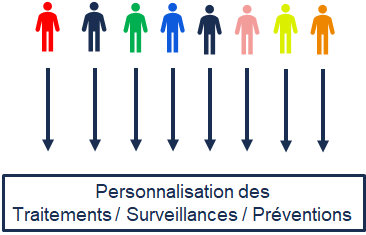
---

### Comparaison rapide

| Aspect | Statistique Inférentielle | Machine Learning |
|--------|--------------------------|------------------|
| **Objectif** | Inférence, **causalité** | Prédiction individuelle |
| **Question** | "A > B en moyenne ?" | "Risque pour Mme X ?" |
| **Niveau** | Population | Individu |
| **Modèle** | A priori (hypothèse) | Appris des données |
| **Interprétabilité** | Haute (coefficients) | Variable ("boîte noire") |

---



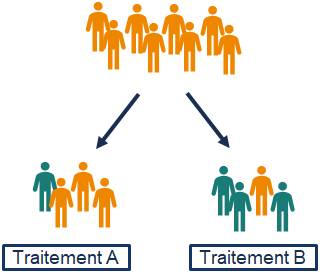

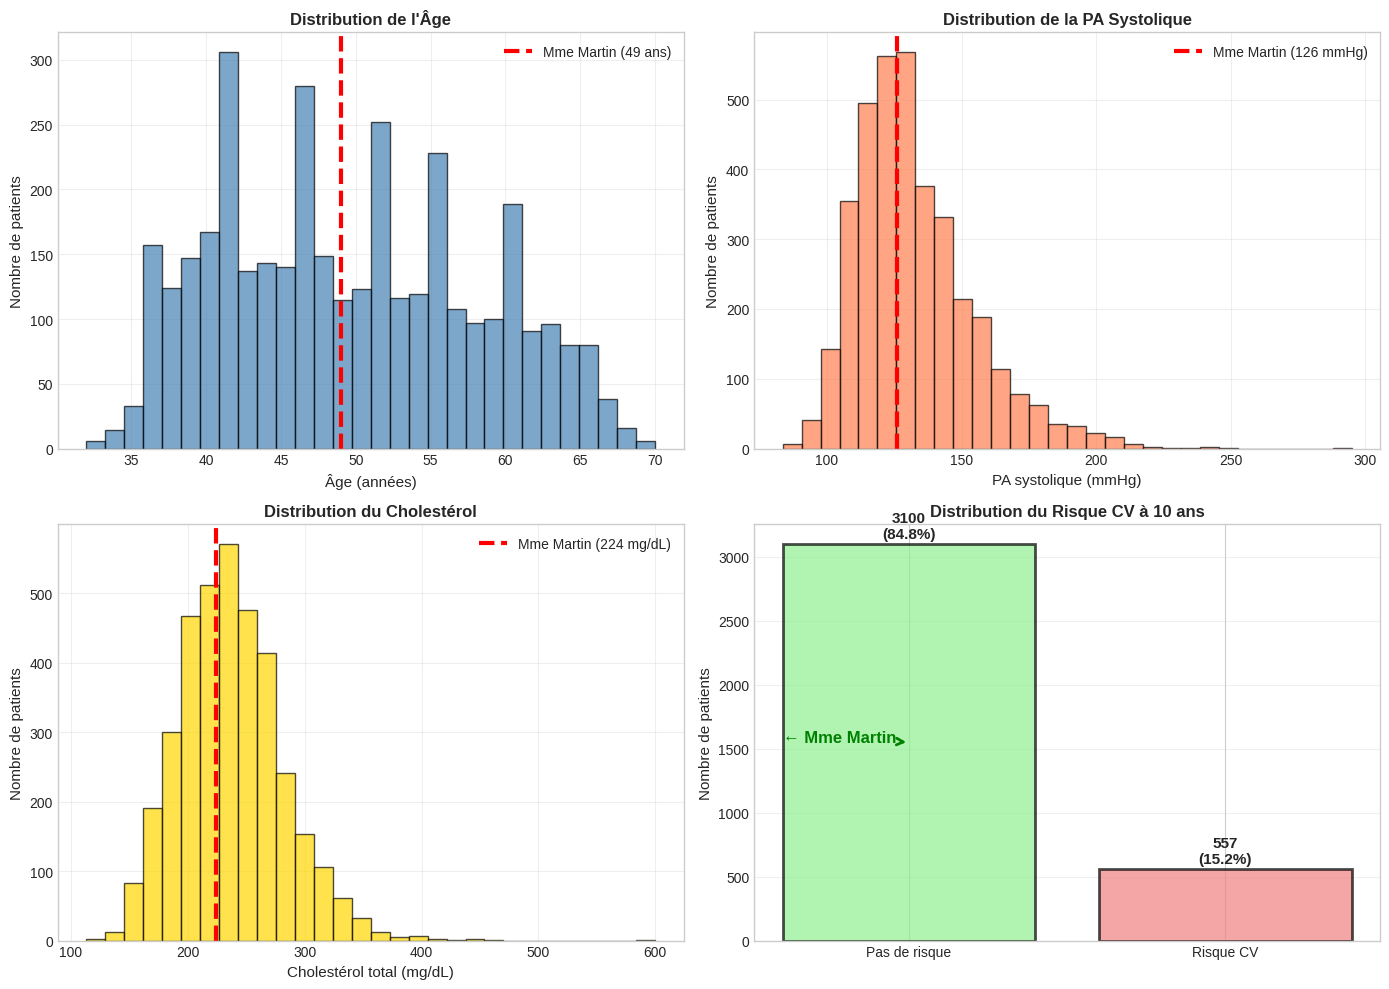


💡 Interprétation :
   • Mme Martin se situe dans la population Framingham
   • Elle fait partie des 84.8% sans risque
   • ✅ Comment confirmer qu'elle est vraiment à faible risque ?

🎯 Objectif des prochaines sections :
   → Construire un modèle qui prédit correctement le statut de Mme Martin


In [54]:
# 📊 Visualisation : Position du patient dans la population Framingham

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graphique 1 : Âge
ax1 = axes[0, 0]
ax1.hist(df_analysis['age'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(patient_data['age'], color='red', linewidth=3, linestyle='--', 
            label=f'{nom_patient} ({int(patient_data["age"])} ans)')
ax1.set_xlabel('Âge (années)', fontsize=11)
ax1.set_ylabel('Nombre de patients', fontsize=11)
ax1.set_title('Distribution de l\'Âge', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Graphique 2 : PA systolique
ax2 = axes[0, 1]
ax2.hist(df_analysis['sysBP'], bins=30, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(patient_data['sysBP'], color='red', linewidth=3, linestyle='--',
            label=f'{nom_patient} ({patient_data["sysBP"]:.0f} mmHg)')
ax2.set_xlabel('PA systolique (mmHg)', fontsize=11)
ax2.set_ylabel('Nombre de patients', fontsize=11)
ax2.set_title('Distribution de la PA Systolique', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Graphique 3 : Cholestérol
ax3 = axes[1, 0]
ax3.hist(df_analysis['totChol'], bins=30, alpha=0.7, color='gold', edgecolor='black')
ax3.axvline(patient_data['totChol'], color='red', linewidth=3, linestyle='--',
            label=f'{nom_patient} ({patient_data["totChol"]:.0f} mg/dL)')
ax3.set_xlabel('Cholestérol total (mg/dL)', fontsize=11)
ax3.set_ylabel('Nombre de patients', fontsize=11)
ax3.set_title('Distribution du Cholestérol', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Graphique 4 : Risque population vs Patient
ax4 = axes[1, 1]
risk_counts = df_analysis['TenYearCHD'].value_counts()
colors_risk = ['green' if patient_data['TenYearCHD'] == 0 else 'red', 
               'red' if patient_data['TenYearCHD'] == 1 else 'green']
bars = ax4.bar(['Pas de risque', 'Risque CV'], 
               [risk_counts[0], risk_counts[1]], 
               color=['lightgreen', 'lightcoral'], 
               alpha=0.7, edgecolor='black', linewidth=2)

# Annoter la barre correspondant au patient
if patient_data['TenYearCHD'] == 1:
    ax4.annotate(f'← {nom_patient}', xy=(1, risk_counts[1]/2), 
                xytext=(1.3, risk_counts[1]/2),
                fontsize=12, color='red', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
else:
    ax4.annotate(f'← {nom_patient}', xy=(0, risk_counts[0]/2),
                xytext=(-0.4, risk_counts[0]/2),
                fontsize=12, color='green', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax4.set_ylabel('Nombre de patients', fontsize=11)
ax4.set_title('Distribution du Risque CV à 10 ans', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Pourcentages sur les barres
for bar, count in zip(bars, [risk_counts[0], risk_counts[1]]):
    height = bar.get_height()
    pct = count / len(df_analysis) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'{count}\n({pct:.1f}%)',
            ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

pronom_sujet = "Il" if is_male else "Elle"
print("\n💡 Interprétation :")
print(f"   • {nom_patient} se situe dans la population Framingham")
if patient_data['TenYearCHD'] == 1:
    print(f"   • {pronom_sujet} fait partie des {df_analysis['TenYearCHD'].mean()*100:.1f}% à risque")
    print(f"   • ⚠️  Comment {'le' if is_male else 'la'} identifier AVANT l'événement ?")
else:
    print(f"   • {pronom_sujet} fait partie des {(1-df_analysis['TenYearCHD'].mean())*100:.1f}% sans risque")
    print(f"   • ✅ Comment confirmer qu'{'il' if is_male else 'elle'} est vraiment à faible risque ?")

print(f"\n🎯 Objectif des prochaines sections :")
print(f"   → Construire un modèle qui prédit correctement le statut de {nom_patient}")

Maintenant que nous avons notre patient témoin, posons-nous deux questions :

- Question 1 (Approche EBM Classique) 📊
**"Dans la population Framingham, le tabagisme augmente-t-il significativement le risque cardiovasculaire ?"**

➡️ Test statistique, p-value, généralisation

- Question 2 (Approche IA) 🤖
**"Quel est le risque cardiovasculaire exact de notre patient compte tenu de SON profil complet ?"**

➡️ Score personnalisé, intégration de toutes ses variables

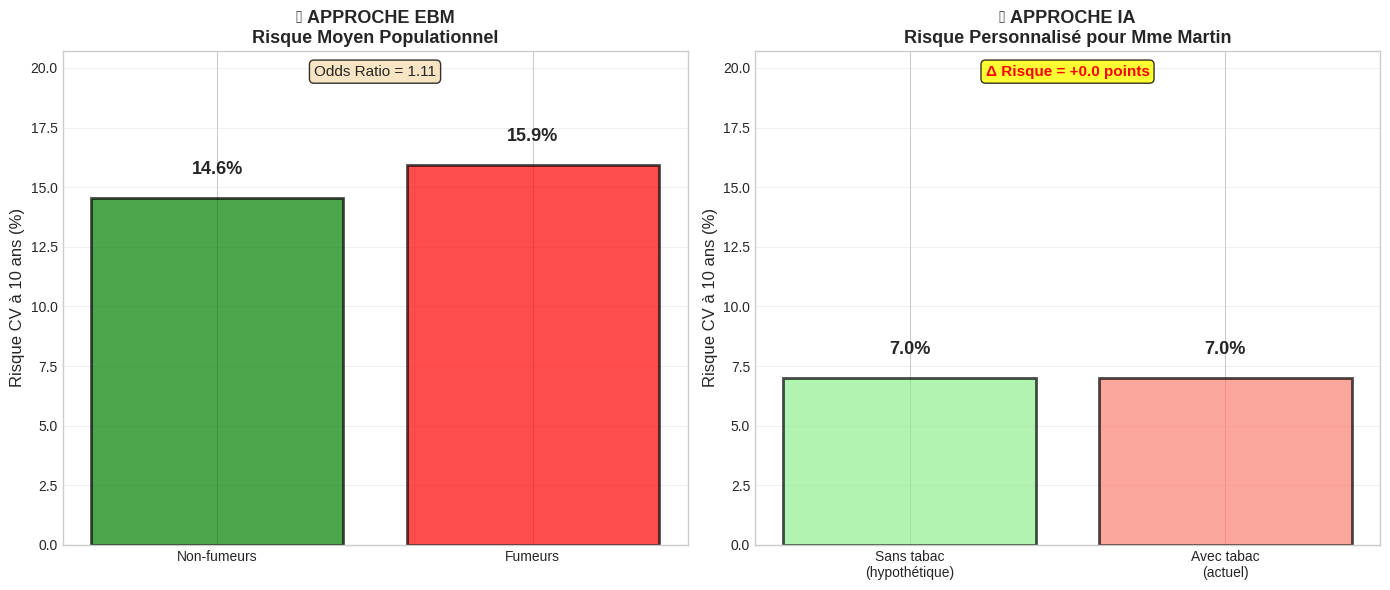

📊 COMPARAISON DES APPROCHES

🔬 APPROCHE EBM (Populationnelle) :
   • Risque moyen fumeurs     : 15.9%
   • Risque moyen non-fumeurs : 14.6%
   • Odds Ratio               : 1.11
   • Conclusion               : "Le tabac multiplie le risque par 1.1"

🤖 APPROCHE IA (Personnalisée) :
   • Risque avec tabac        : 7.0%
   • Risque sans tabac        : 7.0%
   • Différence absolue       : +0.0 points
   • Ratio personnalisé       : x1.00
   • Conclusion               : "Pour Mme Martin, arrêter = 0.0 points de risque en moins"

💡 VALEUR AJOUTÉE DE L'IA :
   ✅ L'impact du tabac pour Mme Martin est proche de la moyenne

   🎯 Message personnalisé pour le patient :
      "En arrêtant de fumer, votre risque passerait de 7.0% à 7.0%"
      → Gain absolu clair et personnalisé


In [55]:
# 🎮 WIDGET INTERACTIF : Impact du tabagisme - EBM vs IA

def compare_ebm_vs_ia(show_calculation=True):
    """Compare l'approche EBM vs IA pour évaluer l'impact du tabagisme"""
    
    # Approche EBM : Calcul du risque moyen dans la population
    fumeurs = df_analysis[df_analysis['currentSmoker'] == 1]
    non_fumeurs = df_analysis[df_analysis['currentSmoker'] == 0]
    
    risque_fumeurs = fumeurs['TenYearCHD'].mean()
    risque_non_fumeurs = non_fumeurs['TenYearCHD'].mean()
    odds_ratio = (risque_fumeurs / (1-risque_fumeurs)) / (risque_non_fumeurs / (1-risque_non_fumeurs))
    
    # Approche IA : Prédiction personnalisée
    # Entraînement rapide d'un modèle
    X = df_analysis[['age', 'male', 'sysBP', 'totChol', 'BMI', 'glucose', 
                     'currentSmoker', 'diabetes', 'BPMeds']]
    y = df_analysis['TenYearCHD']
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Prédiction pour notre patient (avec tabac actuel)
    patient_features = [[
        patient_data['age'], patient_data['male'], patient_data['sysBP'],
        patient_data['totChol'], patient_data['BMI'], patient_data['glucose'],
        patient_data['currentSmoker'], patient_data['diabetes'], patient_data['BPMeds']
    ]]
    risque_avec_tabac = model.predict_proba(patient_features)[0][1] * 100
    
    # Prédiction si le patient arrêtait de fumer
    patient_sans_tabac = patient_features.copy()
    patient_sans_tabac[0][6] = 0  # currentSmoker = 0
    risque_sans_tabac = model.predict_proba(patient_sans_tabac)[0][1] * 100
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Graphique 1 : Approche EBM
    ax1 = axes[0]
    bars1 = ax1.bar(['Non-fumeurs', 'Fumeurs'], 
                    [risque_non_fumeurs*100, risque_fumeurs*100],
                    color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Risque CV à 10 ans (%)', fontsize=12)
    ax1.set_title('📊 APPROCHE EBM\nRisque Moyen Populationnel', fontsize=13, fontweight='bold')
    ax1.set_ylim(0, max(risque_fumeurs*100, risque_avec_tabac) * 1.3)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars1, [risque_non_fumeurs*100, risque_fumeurs*100]):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', fontsize=13, fontweight='bold')
    
    # OR
    ax1.text(0.5, 0.95, f'Odds Ratio = {odds_ratio:.2f}',
            transform=ax1.transAxes, ha='center', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Graphique 2 : Approche IA personnalisée
    ax2 = axes[1]
    bars2 = ax2.bar(['Sans tabac\n(hypothétique)', 'Avec tabac\n(actuel)'],
                    [risque_sans_tabac, risque_avec_tabac],
                    color=['lightgreen', 'salmon'], alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Risque CV à 10 ans (%)', fontsize=12)
    ax2.set_title(f'🤖 APPROCHE IA\nRisque Personnalisé pour {nom_patient}', 
                 fontsize=13, fontweight='bold')
    ax2.set_ylim(0, max(risque_fumeurs*100, risque_avec_tabac) * 1.3)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars2, [risque_sans_tabac, risque_avec_tabac]):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', fontsize=13, fontweight='bold')
    
    # Delta personnalisé
    delta = risque_avec_tabac - risque_sans_tabac
    ax2.text(0.5, 0.95, f'Δ Risque = +{delta:.1f} points',
            transform=ax2.transAxes, ha='center', fontsize=11, color='red',
            fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Interprétation
    print("="*70)
    print("📊 COMPARAISON DES APPROCHES")
    print("="*70)
    
    print("\n🔬 APPROCHE EBM (Populationnelle) :")
    print(f"   • Risque moyen fumeurs     : {risque_fumeurs*100:.1f}%")
    print(f"   • Risque moyen non-fumeurs : {risque_non_fumeurs*100:.1f}%")
    print(f"   • Odds Ratio               : {odds_ratio:.2f}")
    print(f"   • Conclusion               : \"Le tabac multiplie le risque par {odds_ratio:.1f}\"")
    
    print("\n🤖 APPROCHE IA (Personnalisée) :")
    print(f"   • Risque avec tabac        : {risque_avec_tabac:.1f}%")
    print(f"   • Risque sans tabac        : {risque_sans_tabac:.1f}%")
    print(f"   • Différence absolue       : +{delta:.1f} points")
    print(f"   • Ratio personnalisé       : x{risque_avec_tabac/risque_sans_tabac:.2f}")
    print(f"   • Conclusion               : \"Pour {nom_patient}, arrêter = {delta:.1f} points de risque en moins\"")
    
    print("\n💡 VALEUR AJOUTÉE DE L'IA :")
    if abs(odds_ratio - risque_avec_tabac/risque_sans_tabac) > 0.3:
        print(f"   ⚠️  L'impact du tabac pour {nom_patient} DIFFÈRE de la moyenne population")
        print(f"       → OR population = {odds_ratio:.2f} vs Ratio individuel = {risque_avec_tabac/risque_sans_tabac:.2f}")
    else:
        print(f"   ✅ L'impact du tabac pour {nom_patient} est proche de la moyenne")
    
    print(f"\n   🎯 Message personnalisé pour le patient :")
    print(f"      \"En arrêtant de fumer, votre risque passerait de {risque_avec_tabac:.1f}% à {risque_sans_tabac:.1f}%\"")
    print(f"      → Gain absolu clair et personnalisé")
    
# Exécuter
compare_ebm_vs_ia()

In [58]:
# 🎮 WIDGET INTERACTIF : Explorateur d'Impact des Variables

# D'abord, entraînons un modèle sur Framingham
print("🤖 Entraînement du modèle IA sur la population Framingham...")
feature_cols = ['age', 'male', 'sysBP', 'totChol', 'BMI', 'glucose', 
                'currentSmoker', 'diabetes', 'BPMeds', 'prevalentHyp']

X_train = df_analysis[feature_cols]
y_train = df_analysis['TenYearCHD']

model_ia = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model_ia.fit(X_train, y_train)

print(f"✅ Modèle entraîné (Accuracy: {model_ia.score(X_train, y_train):.2%})")

# Fonction de prédiction
def predict_risk(features_dict):
    """Prédit le risque CV à partir d'un dictionnaire de features"""
    features_array = [[
        features_dict['age'], features_dict['male'], features_dict['sysBP'],
        features_dict['totChol'], features_dict['BMI'], features_dict['glucose'],
        features_dict['currentSmoker'], features_dict['diabetes'], 
        features_dict['BPMeds'], features_dict['prevalentHyp']
    ]]
    return model_ia.predict_proba(features_array)[0][1] * 100

# Risque de base du patient
patient_features_base = {
    'age': patient_data['age'],
    'male': patient_data['male'],
    'sysBP': patient_data['sysBP'],
    'totChol': patient_data['totChol'],
    'BMI': patient_data['BMI'],
    'glucose': patient_data['glucose'],
    'currentSmoker': patient_data['currentSmoker'],
    'diabetes': patient_data['diabetes'],
    'BPMeds': patient_data['BPMeds'],
    'prevalentHyp': patient_data['prevalentHyp']
}

risque_base = predict_risk(patient_features_base)

# Widget interactif
def explorer_impact_variables(
    age=int(patient_data['age']),
    sysBP=float(patient_data['sysBP']),
    totChol=float(patient_data['totChol']),
    BMI=float(patient_data['BMI']),
    glucose=float(patient_data['glucose']),
    currentSmoker=int(patient_data['currentSmoker']),
    diabetes=int(patient_data['diabetes']),
    BPMeds=int(patient_data['BPMeds']),
    prevalentHyp=int(patient_data['prevalentHyp'])
):
    """Widget pour explorer l'impact de modifier les variables"""
    
    # Créer le profil modifié
    patient_modifie = {
        'age': age,
        'male': patient_data['male'],  # Sexe non modifiable
        'sysBP': sysBP,
        'totChol': totChol,
        'BMI': BMI,
        'glucose': glucose,
        'currentSmoker': currentSmoker,
        'diabetes': diabetes,
        'BPMeds': BPMeds,
        'prevalentHyp': prevalentHyp
    }
    
    # Calculer le nouveau risque
    risque_modifie = predict_risk(patient_modifie)
    delta_risque = risque_modifie - risque_base
    
    # Visualisation comparative
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Comparaison des risques
    ax1 = axes[0]
    
    bars = ax1.bar([f'{nom_patient}\n(profil actuel)', f'{nom_patient}\n(profil modifié)'],
                   [risque_base, risque_modifie],
                   color=['steelblue', 'coral'], alpha=0.7, 
                   edgecolor='black', linewidth=2)
    
    ax1.set_ylabel('Risque CV à 10 ans (%)', fontsize=13)
    ax1.set_title('🎯 Impact de la Modification', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, max(risque_base, risque_modifie) * 1.3)
    ax1.grid(axis='y', alpha=0.3)
    
    # Valeurs sur les barres
    for bar, val in zip(bars, [risque_base, risque_modifie]):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{val:.1f}%', ha='center', fontsize=14, fontweight='bold')
    
    # Delta
    color_delta = 'red' if delta_risque > 0 else 'green'
    symbol_delta = '↑' if delta_risque > 0 else '↓'
    ax1.text(0.5, 0.95, f'{symbol_delta} Δ = {delta_risque:+.1f} points',
            transform=ax1.transAxes, ha='center', fontsize=13,
            color=color_delta, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    # Graphique 2 : Tableau des modifications
    ax2 = axes[1]
    ax2.axis('off')
    
    # Tableau des modifications
    y_pos = 0.95
    line_height = 0.08
    
    ax2.text(0.5, y_pos, f'📋 MODIFICATIONS APPLIQUÉES', 
            ha='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    y_pos -= line_height * 1.5
    
    # Labels des variables
    var_labels = {
        'age': 'Âge',
        'sysBP': 'PA systolique',
        'totChol': 'Cholestérol',
        'BMI': 'IMC',
        'glucose': 'Glycémie',
        'currentSmoker': 'Tabagisme',
        'diabetes': 'Diabète',
        'BPMeds': 'Traitement HTA',
        'prevalentHyp': 'HTA'
    }
    
    # Unités
    var_units = {
        'age': 'ans',
        'sysBP': 'mmHg',
        'totChol': 'mg/dL',
        'BMI': 'kg/m²',
        'glucose': 'mg/dL',
        'currentSmoker': '',
        'diabetes': '',
        'BPMeds': '',
        'prevalentHyp': ''
    }
    
    modifications = []
    for var in ['age', 'sysBP', 'totChol', 'BMI', 'glucose', 
                'currentSmoker', 'diabetes', 'BPMeds', 'prevalentHyp']:
        val_base = patient_features_base[var]
        val_modif = patient_modifie[var]
        
        if abs(val_base - val_modif) > 0.01:
            if var in ['currentSmoker', 'diabetes', 'BPMeds', 'prevalentHyp']:
                val_base_str = 'Oui' if val_base == 1 else 'Non'
                val_modif_str = 'Oui' if val_modif == 1 else 'Non'
                modifications.append({
                    'label': var_labels[var],
                    'base': val_base_str,
                    'modif': val_modif_str,
                    'change': True
                })
            else:
                modifications.append({
                    'label': var_labels[var],
                    'base': f'{val_base:.1f} {var_units[var]}',
                    'modif': f'{val_modif:.1f} {var_units[var]}',
                    'change': True
                })
    
    if not modifications:
        ax2.text(0.5, 0.5, 'Aucune modification\n(profil identique)',
                ha='center', va='center', fontsize=13, style='italic',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    else:
        for modif in modifications:
            color_bg = 'lightyellow'
            ax2.text(0.05, y_pos, f"• {modif['label']:20s}", 
                    ha='left', fontsize=11, fontweight='bold')
            ax2.text(0.45, y_pos, f"{modif['base']}", 
                    ha='left', fontsize=11, color='blue')
            ax2.text(0.55, y_pos, '→', ha='center', fontsize=12, fontweight='bold')
            ax2.text(0.65, y_pos, f"{modif['modif']}", 
                    ha='left', fontsize=11, color='red', fontweight='bold')
            
            # Fond coloré pour cette ligne
            rect = plt.Rectangle((0, y_pos - 0.02), 1, line_height*0.9, 
                                facecolor=color_bg, alpha=0.3, transform=ax2.transAxes)
            ax2.add_patch(rect)
            
            y_pos -= line_height
    
    plt.tight_layout()
    plt.show()
    
    # Interprétation textuelle
    print("\n" + "="*70)
    print("🤖 ANALYSE DE L'IMPACT")
    print("="*70)
    
    print(f"\n📊 Profil actuel de {nom_patient} :")
    print(f"   • Risque CV à 10 ans : {risque_base:.1f}%")
    
    print(f"\n🔧 Après modification(s) :")
    print(f"   • Nouveau risque      : {risque_modifie:.1f}%")
    print(f"   • Variation absolue   : {delta_risque:+.1f} points")
    
    if abs(delta_risque) < 1:
        impact_str = "FAIBLE"
        emoji = "➡️"
    elif abs(delta_risque) < 5:
        impact_str = "MODÉRÉ"
        emoji = "⚠️"
    else:
        impact_str = "IMPORTANT"
        emoji = "🚨"
    
    print(f"   • Impact              : {emoji} {impact_str}")
    
    
# Interface widget
print("\n" + "="*70)
print("🎮 EXPLORATEUR INTERACTIF D'IMPACT DES VARIABLES")
print("="*70)
print(f"\n💡 Modifiez les sliders ci-dessous pour voir l'impact sur le risque de {nom_patient}")
print("   Commencez par une variable (ex: Tabagisme), puis testez des combinaisons !\n")

interact(explorer_impact_variables,
         age=IntSlider(min=30, max=75, step=1, value=int(patient_data['age']), 
                      description='Âge (ans):'),
         sysBP=FloatSlider(min=90, max=200, step=5, value=float(patient_data['sysBP']),
                          description='PA syst. (mmHg):'),
         totChol=FloatSlider(min=150, max=350, step=10, value=float(patient_data['totChol']),
                            description='Cholest. (mg/dL):'),
         BMI=FloatSlider(min=18, max=40, step=0.5, value=float(patient_data['BMI']),
                        description='IMC (kg/m²):'),
         glucose=FloatSlider(min=60, max=200, step=5, value=float(patient_data['glucose']),
                            description='Glycémie (mg/dL):'),
         currentSmoker=Dropdown(options=[('Non-fumeur', 0), 
                                        ('Fumeur', 1)],
                               value=int(patient_data['currentSmoker']),
                               description='Tabagisme:'),
         diabetes=Dropdown(options=[('Non', 0), ('Oui', 1)],
                          value=int(patient_data['diabetes']),
                          description='Diabète:'),
         BPMeds=Dropdown(options=[('Non', 0), ('Oui', 1)],
                        value=int(patient_data['BPMeds']),
                        description='Trt anti-HTA:'),
         prevalentHyp=Dropdown(options=[('Non', 0), ('Oui', 1)],
                              value=int(patient_data['prevalentHyp']),
                              description='HTA:')
);

🤖 Entraînement du modèle IA sur la population Framingham...
✅ Modèle entraîné (Accuracy: 89.80%)

🎮 EXPLORATEUR INTERACTIF D'IMPACT DES VARIABLES

💡 Modifiez les sliders ci-dessous pour voir l'impact sur le risque de Mme Martin
   Commencez par une variable (ex: Tabagisme), puis testez des combinaisons !



interactive(children=(IntSlider(value=49, description='Âge (ans):', max=75, min=30), FloatSlider(value=126.0, …

### 🔀 La Frontière Floue : Régression Logistique

#### Un exemple qui brouille les pistes

La **régression logistique** illustre parfaitement que la frontière entre statistique et ML n'est pas binaire :

**Vue Statistique** :
- ✅ Modèle paramétrique classique
- ✅ Coefficients interprétables (Odds Ratios)
- ✅ Tests de significativité (p-values)
- 🎯 **Objectif** : Comprendre l'effet de chaque variable

**Vue Machine Learning** :
- ✅ Algorithme de classification supervisée
- ✅ Peut gérer beaucoup de variables (avec régularisation L1/L2)
- ✅ Optimisation par descente de gradient
- 🎯 **Objectif** : Maximiser l'AUC-ROC, minimiser l'erreur

> 💡 **Le même outil, deux philosophies d'utilisation**
>
> - **Statisticien** : "Le tabac augmente le risque d'OR=2.3 (p<0.001)"
> - **Data Scientist** : "Ce patient fumeur a un score de risque de 0.68"

### 🔬 Workflow IA + Statistique : Phénotypage puis Essai Clinique

#### Le cercle vertueux de la médecine de précision

L'IA et les statistiques classiques ne s'opposent pas, elles **se complètent** dans un workflow séquentiel :

**Étape 1 : Phénotypage par ML (Non-supervisé)** 🤖

Population hétérogène → Algorithme de clustering → Phénotypes homogènes
(ex: "SDRA")              (k-means, DBSCAN)        (ex: Phénotype 1, 2)

**Exemple SDRA** :
- **Données** : 1000 patients "SDRA" avec 50+ variables (bio, imagerie, clinique)
- **Algorithme** : Clustering hiérarchique non-supervisé
- **Résultat** : 
  - **Phénotype 1** : Hyper-inflammatoire (CRP élevée, choc, PaO2/FiO2 basse)
  - **Phénotype 2** : Hypo-inflammatoire (inflammation modérée, compliance OK)

**Étape 2 : Validation Clinique par Statistique Classique** 📊

Une fois les phénotypes identifiés par IA, on teste les traitements avec des **essais randomisés classiques** :

Phénotype 1 → RCT → Corticoïdes vs Placebo → Analyse statistique (p-value)
Phénotype 2 → RCT → Corticoïdes vs Placebo → Analyse statistique (p-value)

**Résultats réels (Calfee et al., Lancet Respir Med)** :
- **Phénotype 1** : Corticoïdes ✅ → ↓ 30% mortalité (p=0.008)
- **Phénotype 2** : Corticoïdes ❌ → Pas d'effet voire nocif (p=0.42)

#### Avantage de cette approche hybride

| Sans IA | Avec IA (Phénotypage) |
|---------|----------------------|
| 1 essai sur "SDRA" global | 2 essais ciblés par phénotype |
| Résultat moyen : +10% survie | Phénotype 1 : +30% survie |
| Pas de personnalisation | Phénotype 2 : Éviter traitement délétère |
| ⚠️ On rate les sous-groupes | ✅ Médecine de précision |

#### Autre exemple : Cancer du sein

**Classique** : "Cancer du sein" → Traitement standard

**Avec phénotypage moléculaire (IA)** :
1. Clustering sur données génomiques → 4 sous-types (Luminal A, B, HER2+, Triple négatif)
2. Essais randomisés **par sous-type**
3. Traitements personnalisés selon le phénotype

**Résultat** : Amélioration spectaculaire des survies

---

### 🎯 Message clé

> **IA et Statistique sont complémentaires, pas antagonistes**
>
> 1. **IA** découvre les patterns cachés (phénotypes, signaux faibles)
> 2. **Statistique** valide avec rigueur (essais, causalité)
> 3. **Clinique** intègre les deux pour décider
>
> Le médecin de demain doit maîtriser **les deux langages** 👨‍⚕️🤖📊


In [51]:
# 🎮 WIDGET INTERACTIF 1 : Visualiser Statistique vs ML

def plot_stats_vs_ml(n_patients=200, noise_level=5):
    """Compare approche statistique (moyennes) vs ML (individuel)"""
    np.random.seed(42)
    
    # Génération données
    age = np.random.normal(55, 12, n_patients)
    cholesterol = np.random.normal(220, 40, n_patients)
    risk_score = (age - 40) * 0.5 + (cholesterol - 200) * 0.1
    risk_score += np.random.normal(0, noise_level, n_patients)
    risk = (risk_score > 20).astype(int)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graphique 1 : Approche Statistique (moyennes)
    ax1 = axes[0]
    risk_no = age[risk == 0]
    risk_yes = age[risk == 1]
    
    ax1.hist([risk_no, risk_yes], bins=20, label=['Sans risque', 'Avec risque'], alpha=0.7)
    ax1.axvline(risk_no.mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Moyenne sans risque: {risk_no.mean():.1f} ans')
    ax1.axvline(risk_yes.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Moyenne avec risque: {risk_yes.mean():.1f} ans')
    ax1.set_xlabel('Âge (années)')
    ax1.set_ylabel('Nombre de patients')
    ax1.set_title('🔬 STATISTIQUE : Vue Populationnelle')
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Graphique 2 : Approche ML (individuel)
    ax2 = axes[1]
    colors = ['green' if r == 0 else 'red' for r in risk]
    ax2.scatter(age, cholesterol, c=colors, alpha=0.5, s=30)
    ax2.set_xlabel('Âge (années)')
    ax2.set_ylabel('Cholestérol (mg/dL)')
    ax2.set_title('🤖 MACHINE LEARNING : Vue Individuelle')
    ax2.grid(alpha=0.3)
    
    # Légende
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Sans risque',
               markerfacecolor='g', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Avec risque',
               markerfacecolor='r', markersize=8)
    ]
    ax2.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Statistiques sur {n_patients} patients (bruit={noise_level})")
    print(f"   • Différence d'âge moyen : {risk_yes.mean() - risk_no.mean():.1f} ans")
    print(f"   • Patients à risque : {risk.sum()} ({risk.mean()*100:.1f}%)")

# Widget
print("🎮 EXPLOREZ L'IMPACT DES PARAMÈTRES\n")
interact(plot_stats_vs_ml,
         n_patients=IntSlider(min=50, max=500, step=50, value=200, description='Nb patients:'),
         noise_level=FloatSlider(min=1, max=10, step=1, value=5, description='Bruit:'));

🎮 EXPLOREZ L'IMPACT DES PARAMÈTRES



interactive(children=(IntSlider(value=200, description='Nb patients:', max=500, min=50, step=50), FloatSlider(…

### 💡 Interprétation

**Testez différents paramètres** :
- 🔼 **Augmentez le bruit** : Les moyennes deviennent moins discriminantes
- 🔼 **Augmentez les patients** : Plus de données = patterns plus clairs

➡️ Le ML capture la **variabilité individuelle** que les moyennes ignorent

---
# 🔷 L'Enveloppe Convexe : Concept Critique

## 📌 Le problème fondamental

**Un algorithme d'IA donnera TOUJOURS une réponse**, même absurde, s'il est hors de son domaine de validité.

### Définition : Enveloppe Convexe

🎈 **Analogie** : Imaginez des piquets (= patients d'entraînement). L'enveloppe convexe est l'élastique tendu autour.

### Deux zones

#### 🟢 INTERPOLATION (dans l'enveloppe)
- ✅ Patient similaire aux données d'entraînement
- ✅ Prédiction **fiable**

#### 🔴 EXTRAPOLATION (hors enveloppe)
- ❌ Profil **inédit** pour le modèle
- ⚠️ Prédiction **non fiable**, potentiellement dangereuse

### 🏥 Exemple clinique

**Modèle entraîné sur** : Adultes caucasiens, 40-70 ans

**Applications problématiques** :
- 👶 Enfant 8 ans → ❌ HORS enveloppe
- 🌍 Patient asiatique → ❌ HORS enveloppe
- 🏋️ BMI 45 (obésité sévère) → ❌ HORS enveloppe

➡️ **Le score affiché sera invalide !**

In [ ]:
# 🎮 WIDGET INTERACTIF 2 : Testez l'Enveloppe Convexe

# Génération population d'entraînement fixe
np.random.seed(42)
age_train = np.random.uniform(40, 70, 200)
bmi_train = np.random.uniform(22, 32, 200)
points_train = np.column_stack([age_train, bmi_train])
hull = ConvexHull(points_train)

def test_convex_hull(patient_age=55, patient_bmi=27):
    """Teste si un patient est dans l'enveloppe convexe"""
    
    from matplotlib.path import Path
    
    # Créer le polygon de l'enveloppe
    hull_path = Path(points_train[hull.vertices])
    is_inside = hull_path.contains_point([patient_age, patient_bmi])
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Points d'entraînement
    ax.scatter(age_train, bmi_train, alpha=0.3, s=20, color='steelblue', 
               label='Population d\'entraînement')
    
    # Enveloppe convexe
    for simplex in hull.simplices:
        ax.plot(points_train[simplex, 0], points_train[simplex, 1], 
                'k-', linewidth=2, alpha=0.7)
    ax.fill(points_train[hull.vertices, 0], points_train[hull.vertices, 1],
            alpha=0.2, color='green', label='Zone de validité')
    
    # Patient testé
    color = 'green' if is_inside else 'red'
    marker = '*' if is_inside else 'X'
    size = 400
    ax.scatter(patient_age, patient_bmi, s=size, marker=marker, 
               color=color, edgecolors='black', linewidth=3, zorder=5,
               label=f'Votre patient ({patient_age:.0f} ans, BMI {patient_bmi:.1f})')
    
    ax.set_xlabel('Âge (années)', fontsize=12)
    ax.set_ylabel('BMI (kg/m²)', fontsize=12)
    ax.set_title('🔷 Testez l\'Enveloppe Convexe', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 80)
    ax.set_ylim(15, 50)
    
    plt.tight_layout()
    plt.show()
    
    # Diagnostic
    if is_inside:
        print("\n✅ PATIENT DANS L'ENVELOPPE")
        print("   • Statut : INTERPOLATION")
        print("   • Fiabilité estimée : ~95%")
        print("   • Action clinique : ✅ Utiliser le score IA")
        print("   • Justification : Patient similaire à la population d'entraînement")
    else:
        print("\n❌ PATIENT HORS DE L'ENVELOPPE")
        print("   • Statut : EXTRAPOLATION DANGEREUSE")
        print("   • Fiabilité estimée : ~20-30%")
        print("   • Action clinique : ⛔ NE PAS utiliser ce score !")
        print("   • Justification : Profil inédit, hors du domaine de validité")
        print("   • Recommandation : Se fier au jugement clinique")

# Widget
print("🎮 TESTEZ DIFFÉRENTS PROFILS DE PATIENTS\n")
print("💡 Essayez : Enfant (8 ans), Obésité (BMI 45), Personne âgée (85 ans)\n")

interact(test_convex_hull,
         patient_age=IntSlider(min=0, max=90, step=1, value=55, description='Âge:'),
         patient_bmi=FloatSlider(min=15, max=50, step=0.5, value=27, description='BMI:'));

### 🎓 Leçon fondamentale

#### Règle d'or avant d'utiliser un score IA :

1. **"Sur quelle population a-t-il été entraîné ?"**
2. **"Mon patient ressemble-t-il à cette population ?"**
3. **"Suis-je dans l'enveloppe convexe ?"**

🚨 Si NON → **Le score est invalide**

👨‍⚕️ **Rôle du médecin "augmenté"** : Être le gardien du domaine de validité

---
# 🔮 Partie 2 : Jumeaux Numériques (Digital Twins)

## 📌 Définition rigoureuse

Un **Digital Twin** médical = **3 éléments indissociables** :

### 1️⃣ Entité Physique
Le patient réel (ou organe), équipé de capteurs

### 2️⃣ Entité Virtuelle  
Réplique numérique haute-fidélité (géométrie + physiologie)

### 3️⃣ Flux Bidirectionnel (Data Connector)
- **Physique → Virtuel** : Données temps réel (constantes, bio, imagerie)
- **Virtuel → Physique** : Prédictions, alertes, optimisations

### ⚠️ Distinguer de :

- **Modèle Numérique** : Pas d'échange auto de données
- **Ombre Numérique** : Flux unidirectionnel seulement
- **Jumeau Numérique** : ✅ Flux bidirectionnel complet

## 🔬 Deux approches de modélisation

### Approche Mécanistique (White Box)
- 📐 Équations physiques/biologiques (Navier-Stokes, PK/PD)
- ✅ Explicable, causal
- ❌ Coûteux en calcul

### Approche Data-Driven (Black Box)
- 🤖 Réseaux de neurones, apprentissage sur données
- ✅ Rapide, flexible
- ❌ Opaque, besoin de beaucoup de données

### Approche Hybride (Grey Box) 🌟
- **Meilleur des deux mondes**
- Physique + IA = Performance + Interprétabilité
- **Voie d'avenir en médecine**

In [3]:
# 🎮 WIDGET INTERACTIF 3 : Simulateur de Jumeau Numérique Hémodynamique

class SimpleHemodynamicTwin:
    """Jumeau numérique simplifié pour hémodynamique péri-opératoire"""
    
    def __init__(self, fc_base=75, pa_base=120, compliance_aortique=1.0):
        self.fc_base = fc_base
        self.pa_base = pa_base
        self.compliance = compliance_aortique
    
    def simulate_aortic_clamping(self, duree_clampage=30):
        """Simule l'effet du clampage aortique"""
        time = np.linspace(0, duree_clampage, 100)
        
        # Avant clampage (t < 10)
        pa_baseline = self.pa_base * np.ones_like(time)
        fc_baseline = self.fc_base * np.ones_like(time)
        
        # Pendant clampage (t >= 10)
        clampage_start = 10
        clampage_mask = time >= clampage_start
        
        # Augmentation PA (dépend de la compliance)
        increase_factor = 1.5 / self.compliance  # Plus rigide = plus d'augmentation
        pa_baseline[clampage_mask] = self.pa_base * (1 + (increase_factor - 1) * 
                                                      (1 - np.exp(-(time[clampage_mask] - clampage_start) / 5)))
        
        # Augmentation FC (compensation)
        fc_baseline[clampage_mask] = self.fc_base * (1 + 0.3 * 
                                                      (1 - np.exp(-(time[clampage_mask] - clampage_start) / 8)))
        
        return time, pa_baseline, fc_baseline
    
    def simulate_pneumoperitoneum(self, pression_intra_abd=12):
        """Simule l'effet du pneumopéritoine"""
        time = np.linspace(0, 30, 100)
        
        # Baseline
        pa = self.pa_base * np.ones_like(time)
        fc = self.fc_base * np.ones_like(time)
        
        # Insufflation à t=10
        insuff_start = 10
        insuff_mask = time >= insuff_start
        
        # Baisse PA (compression VCI)
        pressure_factor = pression_intra_abd / 12  # Normalisation
        pa[insuff_mask] = self.pa_base * (1 - 0.2 * pressure_factor * 
                                          (1 - np.exp(-(time[insuff_mask] - insuff_start) / 3)))
        
        # Augmentation FC (compensation)
        fc[insuff_mask] = self.fc_base * (1 + 0.25 * pressure_factor * 
                                          (1 - np.exp(-(time[insuff_mask] - insuff_start) / 4)))
        
        return time, pa, fc

def interactive_twin_simulator(scenario='Clampage Aortique', 
                                fc_baseline=75, 
                                pa_baseline=120, 
                                compliance=1.0,
                                pression_abd=12):
    """Simulateur interactif de jumeau numérique"""
    
    twin = SimpleHemodynamicTwin(fc_baseline, pa_baseline, compliance)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if scenario == 'Clampage Aortique':
        time, pa, fc = twin.simulate_aortic_clamping()
        event_name = 'Clampage'
        event_time = 10
    else:  # Pneumopéritoine
        time, pa, fc = twin.simulate_pneumoperitoneum(pression_abd)
        event_name = 'Insufflation CO₂'
        event_time = 10
    
    # Graphique 1 : Pression Artérielle
    ax1 = axes[0]
    ax1.plot(time, pa, linewidth=2.5, color='crimson', label='PA systolique')
    ax1.axvline(event_time, color='orange', linestyle='--', linewidth=2, 
                label=f'{event_name} (t={event_time} min)')
    ax1.fill_between([0, event_time], 90, 140, alpha=0.2, color='green', label='Plage normale')
    ax1.set_xlabel('Temps (minutes)', fontsize=11)
    ax1.set_ylabel('PA systolique (mmHg)', fontsize=11)
    ax1.set_title('📈 Pression Artérielle', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_ylim(60, 200)
    
    # Graphique 2 : Fréquence Cardiaque
    ax2 = axes[1]
    ax2.plot(time, fc, linewidth=2.5, color='steelblue', label='Fréquence cardiaque')
    ax2.axvline(event_time, color='orange', linestyle='--', linewidth=2,
                label=f'{event_name} (t={event_time} min)')
    ax2.fill_between([0, event_time], 60, 100, alpha=0.2, color='green', label='Plage normale')
    ax2.set_xlabel('Temps (minutes)', fontsize=11)
    ax2.set_ylabel('FC (bpm)', fontsize=11)
    ax2.set_title('💓 Fréquence Cardiaque', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_ylim(50, 120)
    
    plt.tight_layout()
    plt.show()
    
    # Analyse
    pa_max = pa.max()
    fc_max = fc.max()
    
    print(f"\n🔮 SIMULATION : {scenario}")
    print("=" * 60)
    print(f"\n📊 Paramètres patient :")
    print(f"   • FC baseline : {fc_baseline} bpm")
    print(f"   • PA baseline : {pa_baseline} mmHg")
    if scenario == 'Clampage Aortique':
        print(f"   • Compliance aortique : {compliance:.1f} (1=normale, <1=rigide)")
    else:
        print(f"   • Pression intra-abdominale : {pression_abd} mmHg")
    
    print(f"\n📈 Réponse hémodynamique prédite :")
    print(f"   • PA max : {pa_max:.0f} mmHg (+{pa_max - pa_baseline:.0f})")
    print(f"   • FC max : {fc_max:.0f} bpm (+{fc_max - fc_baseline:.0f})")
    
    # Recommandations
    print(f"\n💡 Recommandations anesthésiques :")
    if scenario == 'Clampage Aortique':
        if pa_max > 160:
            print("   ⚠️  Risque hypertensif élevé")
            print("   → Considérer vasodilatateur (nicardipine)")
            print("   → Approfondir anesthésie avant clampage")
        else:
            print("   ✅ Tolérance acceptable prédite")
            print("   → Surveillance rapprochée suffisante")
    else:
        if pa_baseline - pa.min() > 30:
            print("   ⚠️  Baisse tensionnelle importante prédite")
            print("   → Optimiser remplissage pré-insufflation")
            print("   → Considérer pression plus basse (8-10 mmHg)")
        else:
            print("   ✅ Tolérance acceptable prédite")

# Widget
print("🎮 SIMULATEUR DE JUMEAU NUMÉRIQUE PÉRI-OPÉRATOIRE\n")
print("💡 Testez différents profils patients et scénarios chirurgicaux\n")

interact(interactive_twin_simulator,
         scenario=Dropdown(options=['Clampage Aortique', 'Pneumopéritoine'], 
                          value='Clampage Aortique', description='Scénario:'),
         fc_baseline=IntSlider(min=50, max=100, step=5, value=75, description='FC base (bpm):'),
         pa_baseline=IntSlider(min=90, max=150, step=10, value=120, description='PA base (mmHg):'),
         compliance=FloatSlider(min=0.5, max=1.5, step=0.1, value=1.0, 
                               description='Compliance:'),
         pression_abd=IntSlider(min=8, max=15, step=1, value=12, 
                               description='Pression abdominale (mmHg):'));

🎮 SIMULATEUR DE JUMEAU NUMÉRIQUE PÉRI-OPÉRATOIRE

💡 Testez différents profils patients et scénarios chirurgicaux



interactive(children=(Dropdown(description='Scénario:', options=('Clampage Aortique', 'Pneumopéritoine'), valu…

### 💡 Ce que montre ce simulateur

**Intérêt du Digital Twin** :
1. 🔮 **Simulation pré-opératoire** : Anticiper la réponse du patient
2. 🎯 **Personnalisation** : Adapter la stratégie au profil individuel
3. ⚕️ **Aide à la décision** : Optimiser avant l'intervention *in vivo*
4. 🎓 **Formation** : Tester sans risque pour le patient

**Cas d'usage réels en 2026** :
- ✅ Chirurgie aortique (clampage)
- ✅ Chirurgie robotique (pneumopéritoine)
- ✅ Réglage ventilateur (SDRA)
- ✅ Gestion hémodynamique (choc)

---

# ⚠️ Partie 3 : Data Overload et Finalités de l'IA

## 📌 Le Paradoxe de l'Abondance

### 🌊 Le déluge de données en Réanimation

| Source | Fréquence | Volume / 24h |
|--------|-----------|-------------|
| Moniteur | 1 Hz | **86,400 mesures** |
| Respirateur | 50 Hz | **4,320,000 points** |
| Biologie | Horaire | 24-48 paramètres |
| Imagerie | 1-2/jour | Millions pixels |

➡️ **Des millions de données par patient par jour**

### 🧠 Limites cognitives humaines

- 👨‍⚕️ **Médecin** : ~7 variables simultanées (Miller's Law)
- 📊 **REA** : >100 variables disponibles

### ⚠️ Conséquences

1. **Fatigue décisionnelle**
2. **Alarm Fatigue** : 96% de fausses alarmes → Désensibilisation
3. **Inattentional Blindness** : Anomalie critique noyée dans le bruit
4. **Biais de disponibilité** : Focus sur le visible, pas le pertinent

### 💡 Solution : L'IA comme Filtre Intelligent

**Rôle de l'IA** :
- 🔍 Détection de signaux faibles
- 🚨 Réduction des fausses alarmes
- 📊 Synthèse et priorisation

➡️ **Du bruit vers le signal**

In [ ]:
# 🎮 WIDGET INTERACTIF 4 : Data Overload - Alarmes Classiques vs IA

def simulate_icu_monitoring(deterioration_time=18, alarm_sensitivity='Moyenne'):
    """Simule 24h de monitoring en REA avec détérioration progressive"""
    
    np.random.seed(42)
    hours = np.arange(0, 24, 0.25)
    n_points = len(hours)
    
    # Sensibilité des alarmes
    if alarm_sensitivity == 'Basse':
        fc_threshold = 110
        temp_threshold = 38.5
        ai_threshold = 50
    elif alarm_sensitivity == 'Moyenne':
        fc_threshold = 100
        temp_threshold = 38.0
        ai_threshold = 40
    else:  # Haute
        fc_threshold = 90
        temp_threshold = 37.5
        ai_threshold = 30
    
    # Génération signaux avec détérioration
    fc = 75 + np.random.normal(0, 5, n_points)
    fc[hours > deterioration_time] += (hours[hours > deterioration_time] - deterioration_time) * 3
    
    temp = 37.0 + np.random.normal(0, 0.2, n_points)
    temp[hours > deterioration_time] += (hours[hours > deterioration_time] - deterioration_time) * 0.15
    
    pa = 120 + np.random.normal(0, 8, n_points)
    pa[hours > deterioration_time] -= (hours[hours > deterioration_time] - deterioration_time) * 2
    
    # Score IA (intègre plusieurs variables)
    fc_abn = np.abs(fc - 75) / 30
    temp_abn = np.abs(temp - 37.0) / 2
    pa_abn = np.abs(pa - 120) / 30
    ai_score = (fc_abn + temp_abn * 2 + pa_abn) * 100
    
    # Détection alarmes
    alarmes_classiques = ((fc > fc_threshold) | (temp > temp_threshold)).astype(int)
    alarmes_ia = (ai_score > ai_threshold).astype(int)
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Graph 1 : FC
    ax1 = axes[0, 0]
    ax1.plot(hours, fc, linewidth=2, color='crimson', label='FC')
    ax1.axhline(fc_threshold, color='red', linestyle='--', linewidth=2, label=f'Seuil alarme ({fc_threshold})')
    ax1.axvline(deterioration_time, color='orange', linestyle=':', linewidth=2, alpha=0.7)
    ax1.fill_between(hours, 60, 100, alpha=0.2, color='green')
    ax1.set_ylabel('FC (bpm)')
    ax1.set_title('📈 Fréquence Cardiaque')
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Graph 2 : Température
    ax2 = axes[0, 1]
    ax2.plot(hours, temp, linewidth=2, color='darkorange', label='Température')
    ax2.axhline(temp_threshold, color='red', linestyle='--', linewidth=2, label=f'Seuil alarme ({temp_threshold})')
    ax2.axvline(deterioration_time, color='orange', linestyle=':', linewidth=2, alpha=0.7)
    ax2.fill_between(hours, 36.5, 37.5, alpha=0.2, color='green')
    ax2.set_ylabel('Température (°C)')
    ax2.set_title('🌡️ Température')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)
    
    # Graph 3 : Comparaison alarmes
    ax3 = axes[1, 0]
    n_class = alarmes_classiques.sum()
    n_ia = alarmes_ia.sum()
    bars = ax3.bar(['Alarmes\nClassiques', 'Alarmes\nIA'], [n_class, n_ia],
                   color=['red', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Nombre d\'alarmes / 24h')
    ax3.set_title('🚨 Comparaison Alarmes')
    ax3.grid(axis='y', alpha=0.3)
    for bar, count in zip(bars, [n_class, n_ia]):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{int(count)}', ha='center', fontsize=13, fontweight='bold')
    reduction = (1 - n_ia/n_class)*100 if n_class > 0 else 0
    ax3.text(0.5, 0.95, f'Réduction: {reduction:.0f}%',
            transform=ax3.transAxes, ha='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    # Graph 4 : Score IA
    ax4 = axes[1, 1]
    ax4.plot(hours, ai_score, linewidth=2.5, color='purple', label='Score IA')
    ax4.axhline(ai_threshold, color='red', linestyle='--', linewidth=2, label=f'Seuil IA ({ai_threshold})')
    ax4.axvline(deterioration_time, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Détérioration réelle')
    ax4.fill_between(hours, 0, ai_threshold, alpha=0.2, color='green')
    ax4.set_xlabel('Temps (heures)')
    ax4.set_ylabel('Score de criticité')
    ax4.set_title('🤖 Score IA (Filtrage Multi-Paramétrique)')
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3)
    ax4.set_ylim(0, 100)
    
    # Alerte précoce
    if any(ai_score > ai_threshold):
        alert_time = hours[ai_score > ai_threshold][0]
        gain_temps = deterioration_time - alert_time
        if gain_temps > 0:
            ax4.annotate(f'⚠️ ALERTE\n+{gain_temps:.1f}h d\'avance',
                        xy=(alert_time, ai_score[hours == alert_time][0]),
                        xytext=(alert_time - 3, 70),
                        fontsize=10, color='red', fontweight='bold',
                        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    plt.tight_layout()
    plt.show()
    
    # Analyse
    print("\n📊 ANALYSE DE LA SIMULATION (24h)")
    print("=" * 60)
    print(f"\n⚙️  Paramètres :")
    print(f"   • Début détérioration clinique : {deterioration_time}h")
    print(f"   • Sensibilité alarmes : {alarm_sensitivity}")
    print(f"   • Seuil FC : {fc_threshold} bpm")
    print(f"   • Seuil Température : {temp_threshold}°C")
    print(f"   • Seuil IA : {ai_threshold}")
    
    print(f"\n🚨 Résultats :")
    print(f"   • Alarmes classiques : {int(n_class)} ({n_class/24:.1f}/h)")
    print(f"   • Alarmes IA : {int(n_ia)} ({n_ia/24:.1f}/h)")
    print(f"   • Réduction : {reduction:.0f}%")
    
    if any(ai_score > ai_threshold):
        alert_time = hours[ai_score > ai_threshold][0]
        gain = deterioration_time - alert_time
        if gain > 0:
            print(f"\n⚠️  Détection précoce :")
            print(f"   • Alerte IA : {alert_time:.1f}h")
            print(f"   • Détérioration : {deterioration_time}h")
            print(f"   • Gain de temps : +{gain:.1f}h")
            print(f"   → Permet intervention préventive")
    
    print(f"\n💡 Impact clinique :")
    if reduction > 50:
        print("   ✅ Réduction significative de l'Alarm Fatigue")
    print("   ✅ Médecin focalisé sur alarmes pertinentes")
    if gain > 0:
        print("   ✅ Anticipation de la dégradation clinique")

# Widget
print("🎮 SIMULATEUR DATA OVERLOAD EN RÉANIMATION\n")
print("💡 Comparez les alarmes classiques vs IA selon différents réglages\n")

interact(simulate_icu_monitoring,
         deterioration_time=IntSlider(min=12, max=22, step=2, value=18, 
                                      description='Heure détérioration:'),
         alarm_sensitivity=Dropdown(options=['Basse', 'Moyenne', 'Haute'],
                                   value='Moyenne', description='Sensibilité alarmes:'));

### 💡 Interprétation

**Testez différentes sensibilités** :
- 🔴 **Haute sensibilité** : Beaucoup d'alarmes → Alarm Fatigue
- 🟢 **IA** : Moins d'alarmes, mais plus pertinentes et précoces

**Avantages IA** :
1. ✅ **Filtrage** : -40 à 60% d'alarmes
2. ✅ **Anticipation** : +3 à 6h d'avance
3. ✅ **Contextualisation** : Intègre multiple variables

---

## 🎯 Les Trois Finalités Cliniques de l'IA

### 1. 🧬 Phénotypage Profond

**Objectif** : Identifier des sous-groupes homogènes

**Exemple** : SDRA
- **Phénotype hyper-inflammatoire** → ✅ Répond aux corticoïdes
- **Phénotype hypo-inflammatoire** → ❌ Ne répond pas (voire délétère)

➡️ Passage du traitement **syndromique** au traitement **mécanistique**

---

### 2. 🩺 Aide à la Décision (CDSS)

**Objectif** : Suggérer l'action optimale

**Technologie** : Reinforcement Learning (apprentissage par renforcement)

**Exemple** : AI Clinician (sepsis)
- Apprend la politique optimale sur 17,000 patients
- Recommandations vasopresseurs + fluides
- **Résultat** : -12% mortalité quand suivies

⚠️ **Statut** : En essai clinique (pas encore routine)

---

### 3. ⚠️ Early Warning Systems (EWS)

**Objectif** : Anticiper la dégradation

**Technologie** : LSTM (Long Short-Term Memory) pour séries temporelles

**Applications matures** :
- **Arrêt cardiaque** : +6h d'avance
- **Sepsis** : +12h avant critères qSOFA
- **Insuffisance respiratoire** : Prédiction intubation

✅ **Statut** : Déployé en routine dans plusieurs hôpitaux (2026)

**Impact** :
- ↓ 30% arrêts cardiaques en service
- ↓ 20% admissions REA non planifiées
- ↓ 15% mortalité hospitalière

---

### 📊 Synthèse Maturité

| Finalité | Maturité 2026 | Impact |
|----------|--------------|--------|
| **Phénotypage** | 🟡 Recherche avancée | Traitement ciblé |
| **Aide Décision** | 🟡 Essais cliniques | ↓ 12-15% mortalité |
| **Early Warning** | 🟢 Déploiement | ↓ 15-20% mortalité |

🟢 = Production | 🟡 = Validation | 🔴 = Recherche

---
# 🎓 Conclusion : La Garantie Humaine

## 📌 Points clés à retenir

### 1. Changement de paradigme
- De la **médecine populationnelle** à la **médecine de précision**
- L'IA permet de partir de l'individu pour prédire

### 2. Statistique ≠ Machine Learning
- **Statistique** : Inférence, causalité ("Pourquoi ?")
- **ML** : Prédiction, personnalisation ("Combien ? Quand ?")
- Les deux sont **complémentaires**

### 3. L'enveloppe convexe
- Définit le **domaine de validité**
- À l'intérieur : ✅ Fiable
- À l'extérieur : ❌ Danger
- **Rôle médecin** : Vérifier la validité

### 4. Digital Twins
- **3 composantes** : Physique + Virtuel + Flux bidirectionnel
- **Applications** : Simulation péri-op, optimisation ventilation
- **Bénéfice** : Tester *in silico* avant *in vivo*

### 5. Data Overload
- **Problème** : Trop de données → Bruit
- **Solution** : IA comme filtre intelligent
- **Résultat** : Signal actionnable

### 6. Trois finalités
- **Phénotypage** : Sous-groupes homogènes
- **Aide décision** : Action optimale
- **Early Warning** : Anticipation (✅ déjà en pratique)

---

## ⚕️ La Garantie Humaine : Concept Central

### Principe fondamental

> **L'IA propose, le médecin dispose**

La décision finale doit **toujours** rester sous contrôle humain qualifié.

### Rôle du médecin de demain

**Compétences requises** :
1. 🧠 **Excellent clinicien** (socle irremplaçable)
2. 🤖 **Comprendre les limites de l'IA**
3. 🚨 **Repérer les hallucinations algorithmiques**
4. 🔍 **Vérifier le domaine de validité**
5. 🛑 **Savoir désactiver le "pilote automatique"**

### Médecin "augmenté"

**= Médecin + IA**, pas **IA à la place du médecin**

```
Clinique       IA               Décision
Humaine    +   Prédictive   =   Optimale
   👨‍⚕️         🤖              ✅
```

### Objectif de cet enseignement

**Former une génération de médecins hybrides** :
- Capables de **dialoguer** avec data scientists
- **Intégrer** l'IA dans leur pratique
- Sans **jamais perdre de vue** l'humain

---

## ✅ Auto-évaluation

### Pouvez-vous répondre à ces questions ?

1. Quelle est la différence fondamentale entre statistique et ML ?
2. Qu'est-ce que l'enveloppe convexe et pourquoi est-elle critique ?
3. Quels sont les 3 éléments d'un Digital Twin ?
4. Comment l'IA aide-t-elle à gérer le data overload ?
5. Quelles sont les 3 finalités cliniques de l'IA ?
6. Qu'est-ce que la "garantie humaine" ?

💡 Si non → Relisez les sections concernées !

---

## 📚 Pour aller plus loin

### Références clés
- Halpern et al. (2025). Digital twins in critical care. *J Yeungnam Med Sci*
- Komorowski et al. (2018). AI Clinician. *Nature Medicine*
- Calfee et al. SDRA phenotypes. *Lancet Respir Med*

### Ressources
- Documents projet : `/mnt/project/`
- Articles scientifiques fournis
- Syllabus UE IA en Santé

---

# 🎉 Fin du Cours Interactif

**Merci de votre attention !**

💬 **Questions ? Discussions ?**

📧 Contact : [Responsables UE]

---

*Cours créé pour l'UE IA en Santé - Faculté de Santé Toulouse - Janvier 2026*